<h1>Catalytic converter warranty classification model<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dataset-creation" data-toc-modified-id="Dataset-creation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dataset creation</a></span><ul class="toc-item"><li><span><a href="#Model-creation" data-toc-modified-id="Model-creation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Model creation</a></span></li><li><span><a href="#4-block-model" data-toc-modified-id="4-block-model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>4 block model</a></span></li><li><span><a href="#Model-saving" data-toc-modified-id="Model-saving-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Model saving</a></span></li></ul></li></ul></div>

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import datetime
import torch
import imageio
import imageio.v2 as imageio
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import albumentations
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile
from tqdm import tqdm
import pandas as pd

from torchvision import datasets, transforms

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.13). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
img_1 = imageio.imread('/Users/alexeyfilichkin/Desktop/PyTorch/cat_112/photo/cat_17.png')

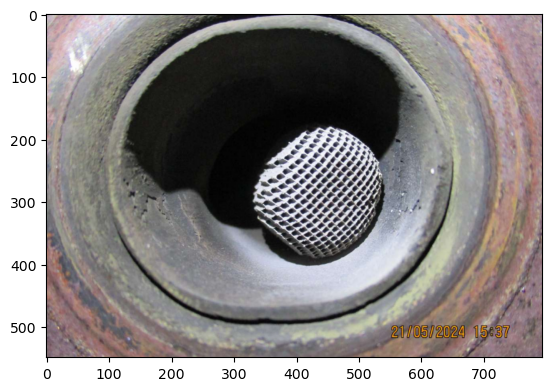

In [3]:
plt.imshow(img_1)
plt.show()

In [4]:
to_tensor = transforms.ToTensor()
img_1 = to_tensor(img_1)
img_1.shape

torch.Size([4, 549, 794])

In [5]:
img_1[0]

tensor([[0.2353, 0.7294,  ..., 0.6431, 0.6275],
        [0.2353, 0.7451,  ..., 0.6667, 0.6549],
        ...,
        [0.2353, 0.4863,  ..., 0.4941, 0.4980],
        [0.2353, 0.4863,  ..., 0.5059, 0.5059]])

In [6]:
img_2 = imageio.imread('/Users/alexeyfilichkin/Desktop/PyTorch/cat_112/photo/cat_43.png')

In [7]:
image = Image.open('/Users/alexeyfilichkin/Desktop/PyTorch/cat_112/photo/cat_43.png')

In [8]:
image = image.convert("RGB")

In [9]:
image = to_tensor(image)
image.shape

torch.Size([3, 564, 765])

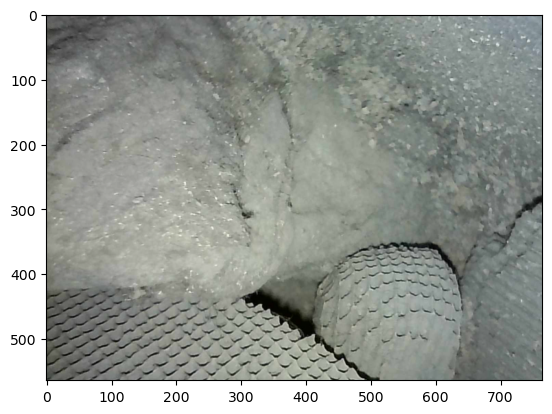

In [10]:
plt.imshow(img_2)
plt.show()

In [11]:
img_2 = to_tensor(img_2)
img_2.shape

torch.Size([4, 564, 765])

## Dataset creation

In [126]:
class ClassificationDataset:
    """
    A general classification dataset class
    """
    def __init__(self, image_paths, targets, resize=None, augmentations=None):
        """
         image_paths: list of path to images
         targets: numpy array
         resize: tuple. Will resizes image if not None
         augmentations: albumentation augmentations of images
        """
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        self.augmentations = augmentations

    def __len__(self):
        """
        Return the total number of samples in the dataset
        """
        return len(self.image_paths)

    def __getitem__(self, item):
        """
        Given an index will get image from dataset
        """
        # PIL to open the image
        image = Image.open(self.image_paths[item])
        # convert image to RGB
        image = image.convert("RGB")
        # get the from data targets
        targets = self.targets[item]
        # resize if Not None
        if self.resize is not None:
            image = image.resize((self.resize[1], self.resize[0]), resample=Image.BILINEAR)
        # convert to numpy array
        image = np.array(image)
        # if albumentation not None
        if self.augmentations is not None:
            augmented = self.augmentations(image=image)
            image = augmented["image"]
        # pytorch expects CHW instead of HWC
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        # Return tensor of images and targets 
        return {"image": torch.tensor(image, dtype=torch.float), "targets": torch.tensor(targets, dtype=torch.long)}

### Model creation

In [127]:
device = (torch.device('mps') if torch.backends.mps.is_available()
          else torch.device('cpu'))
print(f'Training on device {device}')

Training on device mps


In [128]:
class Cat_112(nn.Module):
    def __init__(self):
        super(Cat_112, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 70 * 70, 120)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(120, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 70 * 70)
        out = self.act4(self.fc1(out))
        out = self.fc2(out)
        return out

In [129]:
EPOCHS = 10 # set number of epoch to run 
RANDOM_STATE = 11 # to repproduce results

# path to images
data_path = '/Users/alexeyfilichkin/Desktop/PyTorch/cat_112/photo'

# cuda/cpu device (depends on your settings)
device = (torch.device('mps') if torch.backends.mps.is_available()
          else torch.device('cpu'))
print(f'Training on device {device}')

# load the dataframe of images path and targets 
df = pd.read_excel('/Users/alexeyfilichkin/Desktop/PyTorch/cat_112/target.xlsx')
# add new column with full path
df['full_path_to_images'] = data_path + "/" + df.file_name.values

# image ids and targets values 
images = df.full_path_to_images.values.tolist()
targets = df.target.values


model = Cat_112()
print(model)



Training on device mps
Cat_112(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): Tanh()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): Tanh()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=39200, out_features=120, bias=True)
  (act4): Tanh()
  (fc2): Linear(in_features=120, out_features=2, bias=True)
)


In [130]:
df.target.value_counts()

target
0    59
1    53
Name: count, dtype: int64

In [131]:
len(images)

112

In [132]:
model.to(device)
# mean and std values of RGB channels for imagenet dataset
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
# albumentations is an image augmentation library
aug = albumentations.Compose([albumentations.Normalize(mean, std, max_pixel_value=255.0, always_apply=True)])

# train_test_split date 
train_images, valid_images, train_targets, valid_targets = train_test_split(images,
                                                                            targets,
                                                                            stratify=targets,
                                                                            random_state=RANDOM_STATE)

# set train dataset with batch_size
train_dataset = ClassificationDataset(image_paths=train_images, targets=train_targets, resize=(280, 280), augmentations=aug)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

# set test dataset with batch_size
valid_dataset = ClassificationDataset(image_paths=valid_images, targets=valid_targets, resize=(280, 280), augmentations=aug)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=False)


In [133]:
len(train_loader), len(valid_loader)

(84, 28)

In [134]:
def train(data_loader, model, optimizer, device):
    """
    training for one epoch with selected model and params
     data_loader:  pytorch dataloader
     model: pytorch model
     optimizer: optimizer 
     device: cuda/cpu
    """
    # set training mode 
    model.train()
    # go over every batch of data in data loader
    for data in data_loader:
        inputs = data["image"]
        targets = data["targets"]
        # move inputs/targets to mps/cpu device
        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.int64)
        # zero grad the optimizer
        # do the forward step of model
        outputs = model(inputs)
        # calculate loss
        loss = nn.CrossEntropyLoss()(outputs, targets)
        # backward step the loss
        optimizer.zero_grad()
        loss.backward()
        # step optimizer
        optimizer.step()
        
def evaluate(data_loader, model, device):
    """
    Evaluation for one epoch
    data_loader: this is the pytorch dataloader
    model: pytorch model
    device: cuda/cpu
    """
    # put model in evaluation mode
    model.eval()
    # init lists to store targets and outputs
    final_targets = []
    final_outputs = []
    # no_grad context
    with torch.no_grad():
        for data in data_loader:
            inputs = data["image"]
            targets = data["targets"]
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)
            # generate prediction
            output = model(inputs)
            _, output = torch.max(output, dim=1)
            # convert targets and outputs to lists
            targets = targets.detach().cpu().numpy().tolist()
            output = output.detach().cpu().numpy().tolist()
            # extend the original list
            final_targets.extend(targets)
            final_outputs.extend(output)
            
    return final_outputs, final_targets

In [135]:
EPOCHS = 1000
# simple optimizer
optimizer = optim.SGD(model.parameters(), lr=0.00001)

In [136]:
for epoch in tqdm(range(1, EPOCHS+1)):
    # train 
    train(train_loader, model, optimizer, device=device)

    # predict 
    predictions_v, valid_targets = evaluate(valid_loader, model, device=device)
    # metrics
    accuracy_score = metrics.accuracy_score(valid_targets, predictions_v)
    if epoch == 1 or epoch % 100 == 0:
        print(f"Epoch={epoch}, Valid accuracy_score={accuracy_score}")
#        print(f"Epoch={epoch}, pred={predictions_v}, target={valid_targets}")

  0%|                                          | 1/1000 [00:01<23:57,  1.44s/it]

Epoch=1, Valid accuracy_score=0.5714285714285714


 10%|████                                    | 100/1000 [02:10<19:36,  1.31s/it]

Epoch=100, Valid accuracy_score=0.6785714285714286


 20%|████████                                | 200/1000 [04:21<17:26,  1.31s/it]

Epoch=200, Valid accuracy_score=0.7142857142857143


 30%|████████████                            | 300/1000 [06:32<15:26,  1.32s/it]

Epoch=300, Valid accuracy_score=0.75


 40%|████████████████                        | 400/1000 [08:43<13:04,  1.31s/it]

Epoch=400, Valid accuracy_score=0.8214285714285714


 50%|████████████████████                    | 500/1000 [10:54<10:53,  1.31s/it]

Epoch=500, Valid accuracy_score=0.8214285714285714


 60%|████████████████████████                | 600/1000 [13:05<08:42,  1.31s/it]

Epoch=600, Valid accuracy_score=0.8214285714285714


 70%|████████████████████████████            | 700/1000 [15:16<06:32,  1.31s/it]

Epoch=700, Valid accuracy_score=0.8214285714285714


 80%|████████████████████████████████        | 800/1000 [17:26<04:21,  1.31s/it]

Epoch=800, Valid accuracy_score=0.8214285714285714


 90%|████████████████████████████████████    | 900/1000 [19:39<02:17,  1.37s/it]

Epoch=900, Valid accuracy_score=0.8214285714285714


100%|███████████████████████████████████████| 1000/1000 [21:51<00:00,  1.31s/it]

Epoch=1000, Valid accuracy_score=0.8214285714285714


In [137]:
def training_loop(n_epochs, optimizer, model, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for data in train_loader:
            inputs = data["image"]
            targets = data["targets"]
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.int64)
            outputs = model(inputs)
            loss = nn.CrossEntropyLoss()(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(),
                                                         epoch, loss_train / len(train_loader)))

In [138]:
training_loop(100, optimizer, model, train_loader)

2024-08-18 19:40:50.016182 Epoch 1, Training loss 0.03513494160627791
2024-08-18 19:41:00.534991 Epoch 10, Training loss 0.03458936723126542
2024-08-18 19:41:12.395518 Epoch 20, Training loss 0.034000987626357185
2024-08-18 19:41:24.310516 Epoch 30, Training loss 0.03343026231630661
2024-08-18 19:41:36.395127 Epoch 40, Training loss 0.03287404570506797
2024-08-18 19:41:47.946679 Epoch 50, Training loss 0.03233253850166442
2024-08-18 19:41:59.670014 Epoch 60, Training loss 0.031806017148136606
2024-08-18 19:42:11.917340 Epoch 70, Training loss 0.031293176611403135
2024-08-18 19:42:23.522871 Epoch 80, Training loss 0.030794327501401614
2024-08-18 19:42:35.055558 Epoch 90, Training loss 0.030308630074917648
2024-08-18 19:42:46.607973 Epoch 100, Training loss 0.0298356165918189


In [139]:
def validate(model, train_loader, valid_loader):
    for loader in [train_loader, valid_loader]:
        correct = 0
        total = 0
        with torch.no_grad():
            for data in loader:
                inputs = data["image"]
                targets = data["targets"]
                inputs = inputs.to(device, dtype=torch.float)
                targets = targets.to(device, dtype=torch.float)
            # generate prediction
                output = model(inputs)
                _, predicted = torch.max(output, dim=1)
            # convert targets and outputs to lists
                total += targets.shape[0]
                correct += int((predicted == targets).sum())
        
        print('Accuracy: %f' % (correct / total))        

In [140]:
validate(model, train_loader, valid_loader)

Accuracy: 1.000000
Accuracy: 0.821429


### 4 block model

In [167]:
class Cat_Model(nn.Module):
    def __init__(self, in_channels=3, conv_channels=16):
        super().__init__()

        self.tail_batchnorm = nn.BatchNorm2d(3)

        self.block1 = CatBlock(in_channels, conv_channels)
        self.block2 = CatBlock(conv_channels, conv_channels * 2)
        self.block3 = CatBlock(conv_channels * 2, conv_channels * 4)
        self.block4 = CatBlock(conv_channels * 4, conv_channels * 8)

        self.head_linear = nn.Linear(36992, 2)
#        self.head_softmax = nn.Softmax(dim=1)


    def forward(self, input_batch):
        bn_output = self.tail_batchnorm(input_batch)

        block_out = self.block1(bn_output)
        block_out = self.block2(block_out)
        block_out = self.block3(block_out)
        block_out = self.block4(block_out)

        conv_flat = block_out.view(block_out.size(0), -1)
        
        linear_output = self.head_linear(conv_flat)
        return linear_output


class CatBlock(nn.Module):
    def __init__(self, in_channels, conv_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels, conv_channels, kernel_size=3, padding=1, bias=True,
        )
        self.tahn1 = nn.Tanh()
        self.conv2 = nn.Conv2d(
            conv_channels, conv_channels, kernel_size=3, padding=1, bias=True,
        )
        self.tahn2 = nn.Tanh()

        self.maxpool = nn.MaxPool2d(2)

    def forward(self, input_batch):
        block_out = self.conv1(input_batch)
        block_out = self.tahn1(block_out)
        block_out = self.conv2(block_out)
        block_out = self.tahn2(block_out)

        return self.maxpool(block_out)

In [168]:
model_new = Cat_Model()
optimizer_new = optim.SGD(model_new.parameters(), lr=0.00005)

In [169]:
model_new.to(device)

Cat_Model(
  (tail_batchnorm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): CatBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (tahn1): Tanh()
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (tahn2): Tanh()
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): CatBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (tahn1): Tanh()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (tahn2): Tanh()
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): CatBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (tahn1): Tanh()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (tahn2): Tanh()
    (maxpool): MaxPool2d(kernel_size=2, str

In [170]:
def train(data_loader, model_new, optimizer_new, device):
    """
    training for one epoch with selected model and params
     data_loader:  pytorch dataloader
     model: pytorch model
     optimizer: optimizer 
     device: cuda/cpu
    """
    # set training mode 
    model_new.train()
    # go over every batch of data in data loader
    for data in data_loader:
        inputs = data["image"]
        targets = data["targets"]
        # move inputs/targets to cuda/cpu device
        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.int64)
        # zero grad the optimizer
        # do the forward step of model
        outputs = model_new(inputs)
        # calculate loss
        loss = nn.CrossEntropyLoss(reduction='none')(outputs, targets)
        # backward step the loss
        optimizer_new.zero_grad()
        loss.backward()
        # step optimizer
        optimizer_new.step()
        
def evaluate(data_loader, model_new, device):
    """
    Evaluation for one epoch
    data_loader: this is the pytorch dataloader
    model: pytorch model
    device: cuda/cpu
    """
    # put model in evaluation mode
    model_new.eval()
    # init lists to store targets and outputs
    final_targets = []
    final_outputs = []
    # no_grad context
    with torch.no_grad():
        for data in data_loader:
            inputs = data["image"]
            targets = data["targets"]
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)
            # generate prediction
            output = model_new(inputs)
            _, output = torch.max(output, dim=1)
            # convert targets and outputs to lists
            targets = targets.detach().cpu().numpy().tolist()
            output = output.detach().cpu().numpy().tolist()
            # extend the original list
            final_targets.extend(targets)
            final_outputs.extend(output)
            
    return final_outputs, final_targets

In [171]:
EPOCHS = 20

In [172]:
for epoch in tqdm(range(1, EPOCHS+1)):
    # train 
    train(train_loader, model_new, optimizer_new, device=device)

    # predict 
    predictions_v, valid_targets = evaluate(valid_loader, model_new, device=device)
    # metrics
    accuracy_score = metrics.accuracy_score(valid_targets, predictions_v)
    if epoch == 1 or epoch % 10 == 0:
        print(f"Epoch={epoch}, Valid accuracy_score={accuracy_score}")
#        print(f"Epoch={epoch}, pred={predictions_v}, target={valid_targets}")

  5%|██▏                                         | 1/20 [00:01<00:30,  1.58s/it]

Epoch=1, Valid accuracy_score=0.35714285714285715


 50%|█████████████████████▌                     | 10/20 [00:15<00:15,  1.52s/it]

Epoch=10, Valid accuracy_score=0.5357142857142857


100%|███████████████████████████████████████████| 20/20 [00:30<00:00,  1.53s/it]

Epoch=20, Valid accuracy_score=0.5357142857142857


In [177]:
def training_loop(n_epochs, optimizer, model, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for data in train_loader:
            inputs = data["image"]
            targets = data["targets"]
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.int64)
            outputs = model(inputs)
            loss = nn.CrossEntropyLoss()(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 500 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(),
                                                         epoch, loss_train / len(train_loader)))

In [178]:
training_loop(10000, optimizer_new, model_new, train_loader)

2024-08-14 23:59:54.557365 Epoch 1, Training loss 0.6785248347691127
2024-08-15 00:11:13.276447 Epoch 500, Training loss 0.025818526569504945
2024-08-15 00:22:33.336277 Epoch 1000, Training loss 0.004943577682232424
2024-08-15 00:33:52.022545 Epoch 1500, Training loss 0.002485720041706076
2024-08-15 00:45:10.884753 Epoch 2000, Training loss 0.0016260669942935312
2024-08-15 00:56:28.685346 Epoch 2500, Training loss 0.0012042953431315848
2024-08-15 01:07:46.917466 Epoch 3000, Training loss 0.0009590457442188423
2024-08-15 01:57:26.762330 Epoch 3500, Training loss 0.0008010250859295335
2024-08-15 02:32:40.392840 Epoch 4000, Training loss 0.0006917831829043782
2024-08-15 02:55:59.871374 Epoch 4500, Training loss 0.0006117919864040052
2024-08-15 03:18:43.577971 Epoch 5000, Training loss 0.000551423975150268
2024-08-15 04:16:43.405785 Epoch 5500, Training loss 0.0005042097345501365
2024-08-15 05:30:38.577933 Epoch 6000, Training loss 0.00046621851254351264
2024-08-15 07:00:44.118909 Epoch 65

In [180]:
def validate(model, train_loader, valid_loader):
    for loader in [train_loader, valid_loader]:
        correct = 0
        total = 0
        with torch.no_grad():
            for data in loader:
                inputs = data["image"]
                targets = data["targets"]
                inputs = inputs.to(device, dtype=torch.float)
                targets = targets.to(device, dtype=torch.float)
            # generate prediction
                output = model(inputs)
                _, predicted = torch.max(output, dim=1)
            # convert targets and outputs to lists
                total += targets.shape[0]
                correct += int((predicted == targets).sum())
        
        print('Accuracy: %f' % (correct / total))

In [181]:
validate(model_new, train_loader, valid_loader)

Accuracy: 1.000000
Accuracy: 0.714286


### Model saving

In [183]:
torch.save(model.state_dict(), '/Users/alexeyfilichkin/Desktop/PyTorch/cat_112/' + 'cat_112_v1.pt')

In [184]:
torch.save(model_new.state_dict(), '/Users/alexeyfilichkin/Desktop/PyTorch/cat_112/' + 'cat_112_v2.pt')

In [185]:
loaded_model = Cat_112()

In [188]:
loaded_model.load_state_dict(torch.load('/Users/alexeyfilichkin/Desktop/PyTorch/cat_112/' + 'cat_112_v1.pt',
                                       map_location=device))

/var/folders/rh/t5mb2sd16vx4tdlfd33x10mm0000gn/T/ipykernel_19736/2583952049.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('/Use

<All keys matched successfully>

In [189]:
loaded_model

Cat_112(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): Tanh()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): Tanh()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=39200, out_features=120, bias=True)
  (act4): Tanh()
  (fc2): Linear(in_features=120, out_features=2, bias=True)
)